# Explore annotations from Rana sierrae 2022 annotated dataset
This notebook will explore an [annotated dataset](https://datadryad.org/stash/downloads/download_resource/0?share=aR1YcRD1JbxzYe3oRLRCHH60_C6QBjWq9lKthC0ODr4) of Rana sierrae vocalizations. The dataset contains mp3 audio files and Raven-formatted annotation text files. We will use OpenSoundscape to load and explore the annotations. 

The annotated data consists of 672 10-second files recorded by underwater autonomous audio recorders. Each file was annotated using Raven annotation software, and five vocalization types of _Rana sierrae_ were annotated. The annotations of the five call types correspond to the descriptions in the associated manuscript:

A primary vocalization "meow" described in Vredenburg et al 2007

B stuttered vocalization, also described in Vredenburg et al 2007

C chuck, double/triple chuck calls

D short downward single note

E frequency-modulated call

X: could not determine if sound is R. sierrae or not; these were excluded from training and validation of the CNN 


This notebook is part of a series of notebooks in the [repository](https://github.com/kitzeslab/rana-sierrae-cnn):

(1) Explore annotated dataset of Rana sierrae call types

(2) Prepare annotated files for training a Convolutional Nerual Network (CNN) machine learning model

(3) Train a CNN to recognize Rana sierrae vocaliztaions

(4) Analyze the accuracy and performance of the CNN

(5) Use the CNN to detect vocalizations in unlabeled data

(6) Analyze temporal patterns of vocal activity using the CNN detections


### Imports
Import required packages

In [1]:
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram

import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for big visuals
%config InlineBackend.figure_format = 'retina'
from opensoundscape.annotations import BoxedAnnotations


### plotting settings
Modify default plotting settings for nice visuals

In [2]:
from matplotlib import pyplot as plt

# create style sheet?
# plt.style.use('./styles/sam.mplstyle')

small_txt = 7
med_txt = 8
big_txt = 8
# set text sizes
plt.rcParams['font.size'] = small_txt
plt.rcParams['axes.labelsize'] = med_txt
plt.rcParams['axes.titlesize'] = big_txt
plt.rcParams['xtick.labelsize'] = small_txt
plt.rcParams['ytick.labelsize'] = small_txt
plt.rcParams['legend.fontsize'] = med_txt
plt.rcParams['figure.titlesize'] = big_txt
# opaque legend (<1 is not fully opaque)
plt.rcParams["legend.framealpha"] = 1.0
# set figure size
plt.rcParams['figure.figsize']=[6,2.5]
plt.rcParams['figure.dpi'] = 300
# set default font
# plt.rcParams['font.sans-serif'] = "Gill Sans"
plt.rcParams['font.family'] = "sans-serif"
# plt.rcParams['font.sans-serif'] = "gillsans"


# TIP use these 2 lines to list all available fonts:
# from matplotlib import font_manager
# font_manager.findSystemFonts(fontpaths=None, fontext="ttf")

# to add a font
# on linux, add .ttf font files to /usr/share/fonts/truetype/
# then follow these instructions https://scentellegher.github.io/visualization/2018/05/02/custom-fonts-matplotlib.html 

# tell matplotlib to create vector fonts 
# so you can edit them later! eg in Illustrator
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# plt.rcParams['lines.markersize'] = 1


#color and line style cycles #
# TIP: use https://coolers.co to create nice color palettes
#or modify this one https://coolors.co/35aad8-f3b61f-ba3b54-45b69c-8a96d7
from cycler import cycler
default_cycler = (cycler(color=['#35aad8','#f3b61f','#8a96d7','#45b69c','#ba3b54']) +
                  cycler(linestyle=['-', '--', '-.', ':','-']))
plt.rc('lines', linewidth=0.5)
plt.rc('axes', prop_cycle=default_cycler)

#use appropriate resolution for retina screens
%config InlineBackend.figure_format='retina'

# Load all annotation tables from Raven files

<!-- Running this cell will download the annotated dataset and save it to the same directory as this notebook. 
 -->
 
<!--  %%bash
curl -L https://datadryad.org/stash/downloads/download_resource/0?share=aR1YcRD1JbxzYe3oRLRCHH60_C6QBjWq9lKthC0ODr4 -->


Visit this link to download the dataset:  https://datadryad.org/stash/share/aR1YcRD1JbxzYe3oRLRCHH60_C6QBjWq9lKthC0ODr4

The size of the dataset is approximately 40 Mb. Download time will depend on the speed of your internet connection. 

After downloading the data from the link:

(1) unzip the downloaded folder `doi_10.5061_dryad.9s4mw6mn3__v1` (double click or right click->unzip)

(2) unzip the inner folder `rana_sierrae_2022`

(3) change the path in the following cell to the location of the unzipped `rana_seirrae_2022` folder:

In [3]:
data_dir='/Users/SML161/Downloads/doi_10.5061_dryad.9s4mw6mn3__v1/rana_sierrae_2022'

The table `audio_and_raven_files.csv` in the dataset pairs each audio file in the dataset with the corresponding annotation file. 

We'll load this table into a DataFrame called `file_df`:

In [4]:
file_df=pd.read_csv(f'{data_dir}/audio_and_raven_files.csv')

 ## Load the Raven annotations using OpenSoundscape
 
 The OpenSoundscape class BoxedAnnotations can parse Raven-formatted annotation files, loading them into a dataframe that can be easily summarized and manipulated. 
 
We'll use our DataFrame `file_df` to summarize the number of each call type annotated in each file. 

In [5]:
# Five vocalization types (A, B, C, D, E) are annotated in this dataset
# the annotation 'X' is used for unknown vocalizations
labels = ['A','B','C','D','E','X'] 

#loop through each pair of audio files and corresponding raven files 
for i in file_df.index:
    #full path to raven annotation .txt file
    raven_file = f"{data_dir}/{file_df.at[i,'raven']}"
    
    # load the Raven annotations into OpenSoundscape with the BoxedAnnotations class
    ba = BoxedAnnotations.from_raven_file(raven_file,annotation_column='annotation')
    for label in labels:
        file_df.at[i, label]=len(ba.df[ba.df['annotation']==label])

Let's look at the first few rows of `file_df`: the table contains the number of annotations of each vocalization type for each annotated file.

In [6]:
file_df.head()

,name,audio,raven,A,B,C,D,E,X
0,sine2022a_MSD-0558_20220624_010000_0-10s,mp3/sine2022a_MSD-0558_20220624_010000_0-10s.mp3,raven_selection_tables/sine2022a_MSD-0558_2022...,0.0,0.0,0.0,0.0,0.0,0.0
1,sine2022a_MSD-0558_20220626_054500_0-10s,mp3/sine2022a_MSD-0558_20220626_054500_0-10s.mp3,raven_selection_tables/sine2022a_MSD-0558_2022...,0.0,0.0,0.0,1.0,0.0,0.0
2,sine2022a_MSD-0558_20220621_190000_0-10s,mp3/sine2022a_MSD-0558_20220621_190000_0-10s.mp3,raven_selection_tables/sine2022a_MSD-0558_2022...,0.0,0.0,0.0,0.0,0.0,0.0
3,sine2022a_MSD-0558_20220622_123000_0-10s,mp3/sine2022a_MSD-0558_20220622_123000_0-10s.mp3,raven_selection_tables/sine2022a_MSD-0558_2022...,1.0,0.0,0.0,0.0,0.0,0.0
4,sine2022a_MSD-0558_20220623_054500_0-10s,mp3/sine2022a_MSD-0558_20220623_054500_0-10s.mp3,raven_selection_tables/sine2022a_MSD-0558_2022...,0.0,0.0,0.0,2.0,0.0,0.0


### Summarize annotations

Let's look at a few summary statistics to get a sense of the contents of the annotated dataset

Number of annotated 10-second clips:

In [7]:
len(file_df)

672

Count of each annotation category: A-E are call types, X is unknown sounds

In [8]:
file_df[labels].sum()

A    763.0
B     34.0
C    131.0
D    103.0
E    205.0
X    129.0
dtype: float64

Number of clips with 1+ _Rana sierrae_ annotation (exclude the 'X' class which is for unknown sounds)

In [9]:
call_types=['A','B','C','D','E']
(file_df[call_types].max(1)>0).sum()

434

Total number of Rana sierrae annotations: 

In [10]:
file_df[call_types].sum().sum()

1236.0

## Inspect temporal patterns

The annotated dataset contains one 10-second annotated audio file starting every 15 minutes for a 7 day period. 

Let's look at temporal patterns in the annotated dataset by summarizing annotations of each call type across the day. 

First, we'll add information about the date and time of each recording into our file_df table

In [13]:
from opensoundscape.audiomoth import audiomoth_start_time
import pytz
from datetime import datetime
import matplotlib

# time zone to localize these recordings
# they were recorded in California, so the local timezone is US/Pacific
tz = pytz.timezone('US/Pacific')

#helper function to extract the timestamp information from the file path
strp_name = lambda f: '_'.join(Path(f).name.split('_')[2:4])+'.wav'

# add columns to file_df for date, time, and combined datetime object
file_df['date']=[audiomoth_start_time(strp_name(f)).astimezone(tz).date() for f in file_df.audio]
file_df['time']=[audiomoth_start_time(strp_name(f)).astimezone(tz).time() for f in file_df.audio]
file_df['dt']=[audiomoth_start_time(strp_name(f)).astimezone(tz) for f in file_df.audio]


### Plot daily activity patterns for each call type

/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_46236/3178842569.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dvar = file_df.groupby('time').sum()/7 / 17


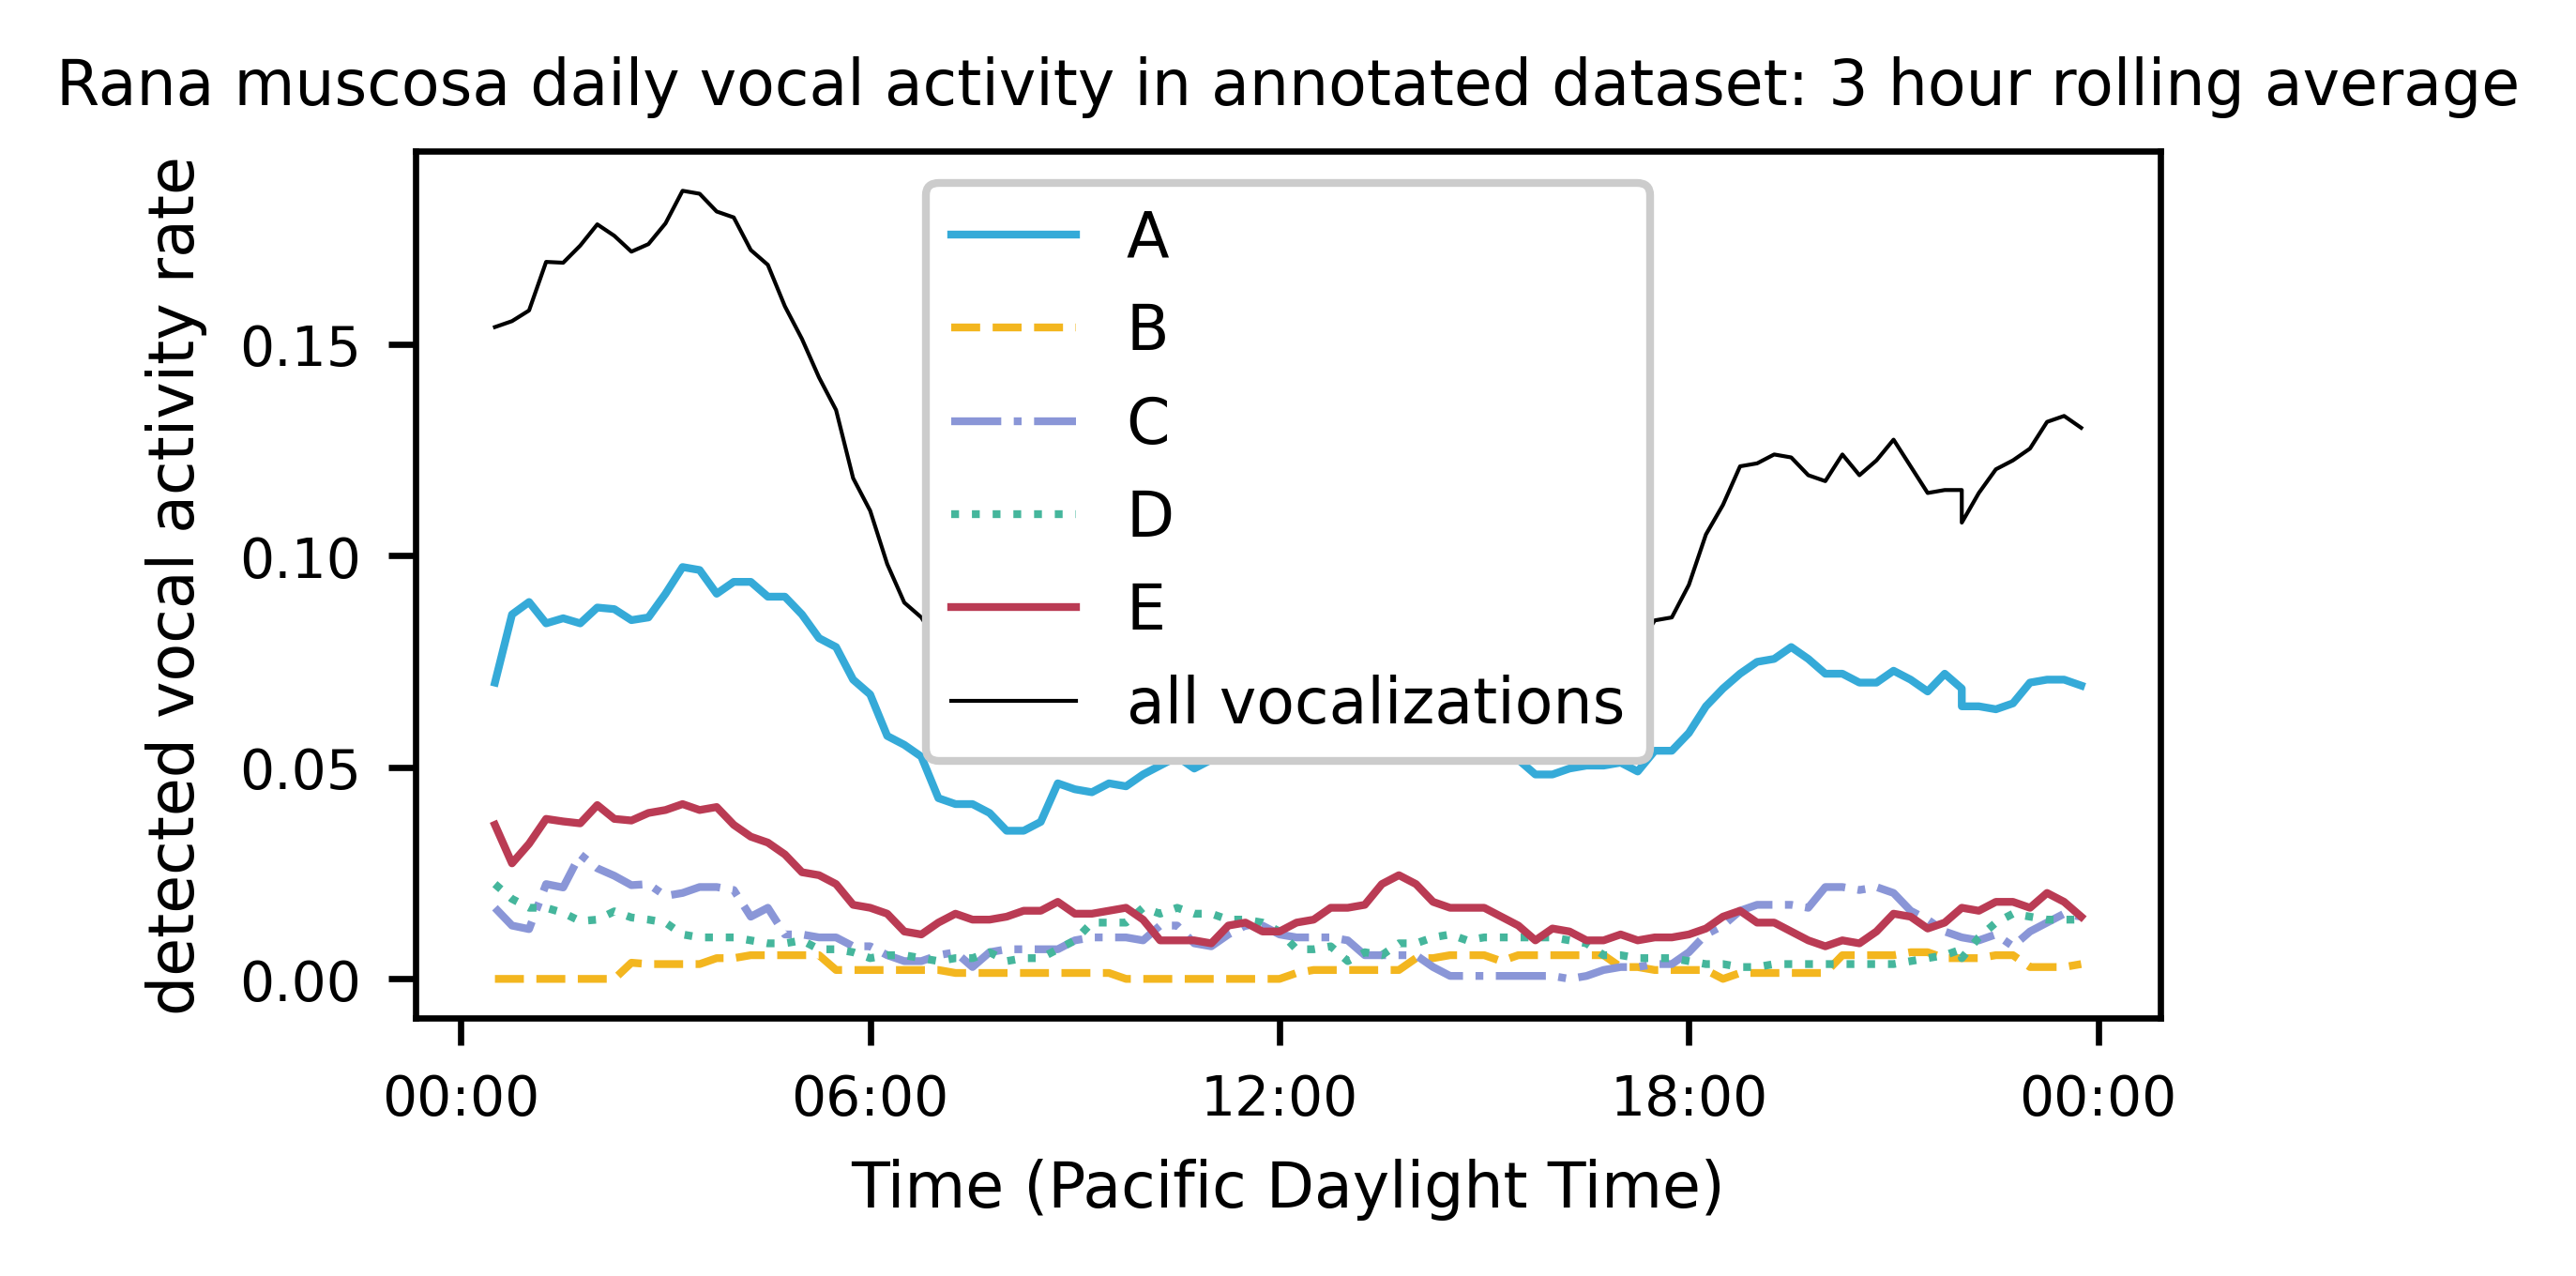

In [14]:
plt.figure(figsize=(4,2)) 

# Detected Vocal Activity Rate: fraction of clips per time period containing a vocalization
# divide # annotations by 17 because there are 17 2-second clips per 10 seconds; 
# and by 7 (one clip at each time of day for 7 consecutive days)
dvar = file_df.groupby('time').sum()/7 / 17

#plot a line for each call type: dvar vs time of day
x_axis = [datetime.combine(datetime.today(),t) for t in dvar.index]
for call_type in call_types: #leave out the "X" label, which is for unknowns
    # plt.scatter(x_axis,activity[call_type],label=call_type,alpha=0.3,linewidths=0,s=4)
    plt.plot(x_axis,dvar[call_type].rolling(12,min_periods=3).mean(),label=call_type,linewidth=1)

# plot a line for any call type
plt.plot(x_axis,dvar.sum(axis=1).rolling(12,min_periods=3).mean(),label='all vocalizations',c='black')

# PLOTTING SETTINGS
ax = plt.gca()
#reformat x ticks to time
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
# use less axis labels
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.legend()
ax.set_xlabel('Time (Pacific Daylight Time)')
ax.set_ylabel('detected vocal activity rate')
# ax.set_ylim(0,0.025)

# plt.xticks(rotation=90)
plt.legend()
plt.title("Rana muscosa daily vocal activity in annotated dataset: 3 hour rolling average")

plt.savefig('./figures/daily_patterns_by_call_type_annotated.pdf')
plt.show()

# Inspect patterns across the seven days

There seems to be a daily pattern of higher activity between midnight and 6am in the figure above. Let's check if this pattern is consistent across the seven days of annotated audio by plotting each day separately, along with the average across the seven days. 

here, dvar (detected vocal activity rate) is 3-hour rolling average of the proportion of 10-second clips containing a vocalization.

/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_46236/856952438.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dvar = file_df.groupby('time').sum()/7/17
/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_46236/856952438.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  y=dfi.sum(axis=1).rolling(12,min_periods=3).mean()/17


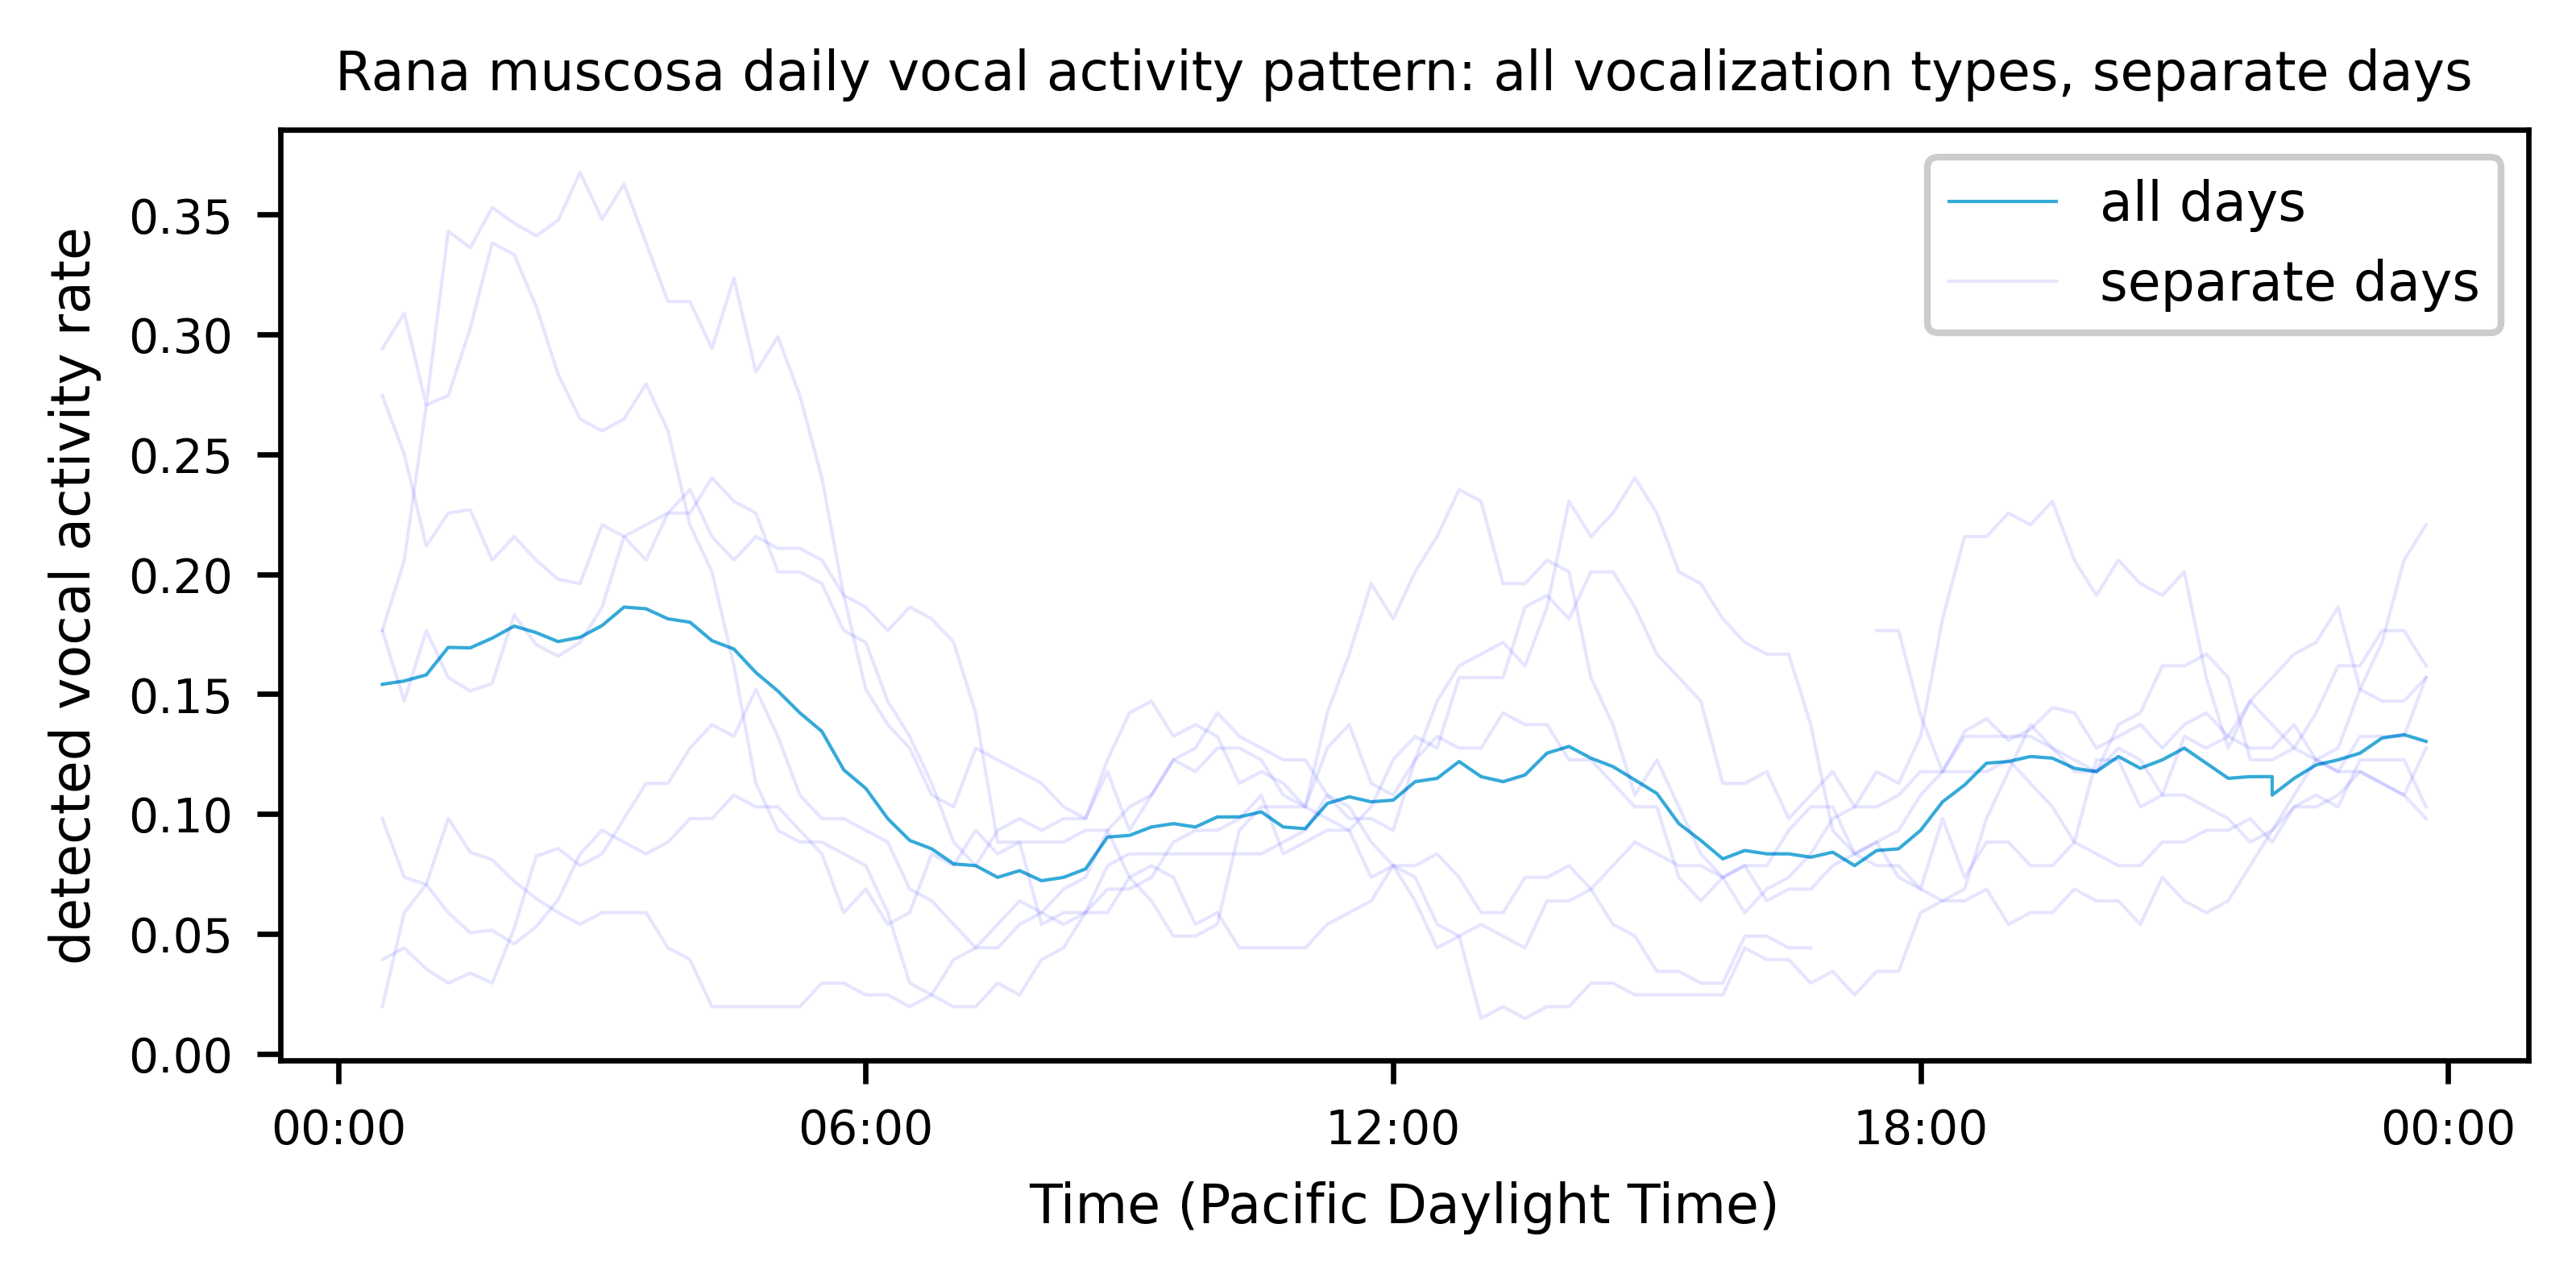

In [17]:
dvar = file_df.groupby('time').sum()/7/17

x_axis = [datetime.combine(datetime.today(),t) for t in dvar.index]

# plot the average of all days as a dark blue line
plt.plot(x_axis,dvar.sum(axis=1).rolling(12,min_periods=3).mean(),label='all days')

# plot each day as a separate light-blue line
for day in file_df.date.unique():
        dfi = file_df[file_df.date==day].sort_values(by='time')
        x_axis = [datetime.combine(datetime.today(),t) for t in dfi.time]
        y=dfi.sum(axis=1).rolling(12,min_periods=3).mean()/17
        plt.plot(x_axis,y,alpha=0.1,c='blue',linestyle='-')


# PLOTTING SETTINGS
ax = plt.gca()
#reformat x ticks to time
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
# use less axis labels
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.legend({'all days':0,'separate days':1})
ax.set_xlabel('Time (Pacific Daylight Time)')
ax.set_ylabel('detected vocal activity rate')
plt.title("Rana muscosa daily vocal activity pattern: all vocalization types, separate days")
plt.savefig('./figures/daily_pattern_separate_days.pdf')
plt.show()

# Pattern of activity across the week

Let's check if vocal activity changed over the course of the seven day period of annotated data by plotting the average number of annotations per 10-second file on each day. We'll plot the primary vocalizations (A and E classes), the other vocalizations (B, C, and D), and the combination of all of them. 

/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_46236/1358732242.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  season = file_df.groupby('date').mean()


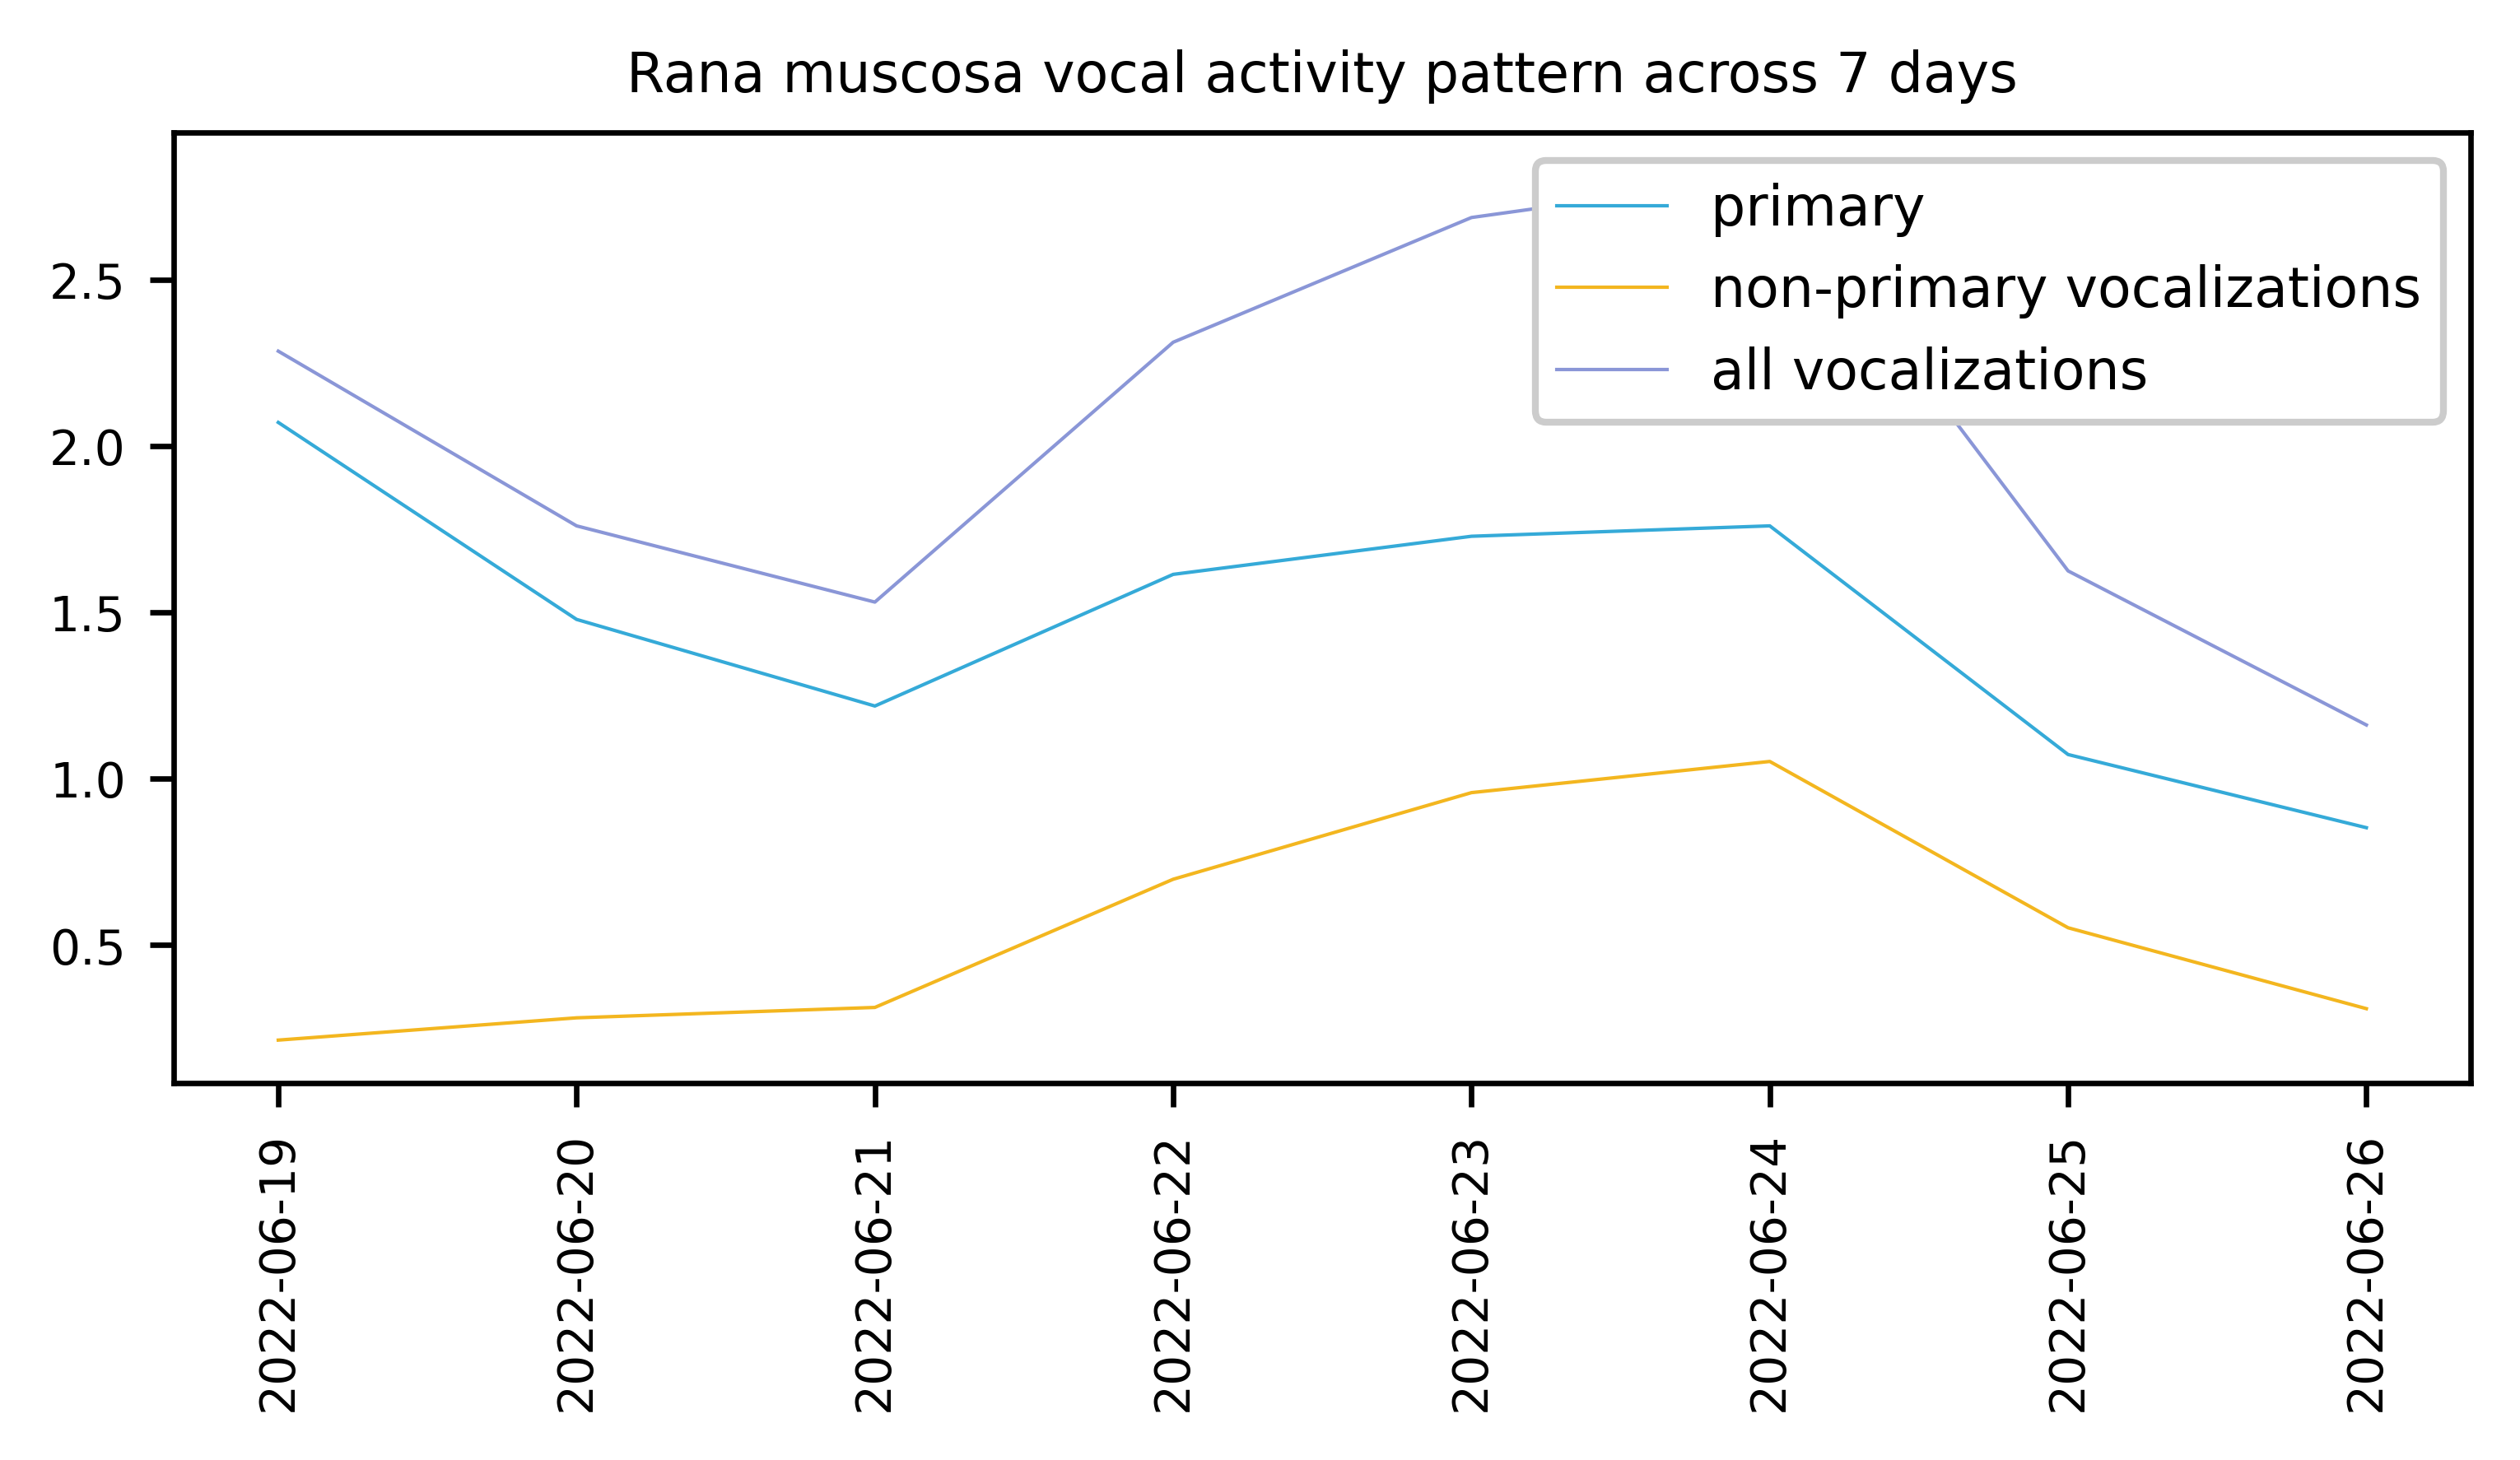

In [19]:
season = file_df.groupby('date').mean()
plt.plot(season.index,season.A+season.E,label='primary',linestyle='-')
plt.plot(season.index,season.sum(axis=1)-(season.A+season.E),label='non-primary vocalizations',linestyle='-')
plt.plot(season.index,season.sum(axis=1),label='all vocalizations',linestyle='-')

plt.xticks(rotation=90)
plt.legend()
plt.title("Rana muscosa vocal activity pattern across 7 days")
plt.savefig('./figures/vocal_activity_annotated_7_days.pdf')
plt.show()